In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import pandas as pd
import scipy.stats
import my_utils as myf
import matplotlib.path as mpath
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import xesmf as xe

In [2]:
mydir = './data/atm_spatial_mean_trend/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'atm_climtrend.1979' in f]
mynames = sorted(list(set([f.split('.')[0].split('/')[-1] for f in myfiles])))

In [3]:
listds = []
for file in myfiles: 
        ds = xr.open_dataset(file)
        ds = ds.set_coords('names')
        if 'lev' in ds:
            ds = ds.drop('lev')
        listds.append(ds)
ds = xr.concat(listds,dim='names')

In [4]:
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'Z3' in f]
listds = []
for file in myfiles: 
        gphds = xr.open_dataset(file)
        listds.append(gphds)
gphds = xr.concat(listds,dim='names')
gphds['season'] = ['DJF','MAM','JJA','SON']

In [5]:
ds = xr.merge([ds, 
gphds.T_trend.sel(plev=200).to_dataset(name='T200_trend').drop('plev'), gphds.T_p_value.sel(plev=200).to_dataset(name='T200_p_value').drop('plev'),
gphds.T_trend.sel(plev=500).to_dataset(name='T500_trend').drop('plev'), gphds.T_p_value.sel(plev=500).to_dataset(name='T500_p_value').drop('plev'),
gphds.Z3_trend.sel(plev=200).to_dataset(name='Z200_trend').drop('plev'), gphds.Z3_p_value.sel(plev=200).to_dataset(name='Z200_p_value').drop('plev'),
gphds.Z3_trend.sel(plev=500).to_dataset(name='Z500_trend').drop('plev'), gphds.Z3_p_value.sel(plev=500).to_dataset(name='Z500_p_value').drop('plev')])


In [6]:
thelens = [f for f in ds.names.values if 'LENS' in f]
lensmean = ds.isel(names=0).copy()
for var in ds:
    lensmean[var] = ds[var].sel(names=thelens).mean(dim='names')
lensmean['names'] = 'LENSmean'
lensmean =lensmean.set_coords('names')

In [7]:
thenudge = ['anom_nudge_era_60','anom_nudge_era_60_arclo','anom_nudge_era_60_archi']
a60nudgemean = ds.isel(names=0).copy()
for var in ds:
    a60nudgemean[var] = ds[var].sel(names=thenudge).mean(dim='names')
a60nudgemean['names'] = 'aNUDGEmean'
a60nudgemean = a60nudgemean.set_coords('names')

In [8]:
ds = xr.concat([ds, lensmean, a60nudgemean],dim='names')

In [9]:
mynames = ['ERAI','LENSmean','aNUDGEmean'] 

In [10]:
myvars = [f for f in ds if 'trend' in f]

In [11]:
northds = ds.where(ds.lat>70.,drop=True).stack(z=("lat", "lon"))

In [12]:
print('Pattern correlations between ERA-Interim and aNUDGEmean north of 70')
for seas in ['DJF','JJA']:
    for var in ['PS_trend','U_trend','V_trend']:
        corr, pval = myf.pearson(northds[var].sel(season=seas).sel(names='ERAI'), northds[var].sel(season=seas).sel(names='aNUDGEmean'), 'z')
        print(seas+'-----'+var+'---{:.2f}'.format(corr.values))

Pattern correlations between ERA-Interim and aNUDGEmean north of 70
DJF-----PS_trend---0.96
DJF-----U_trend---0.84
DJF-----V_trend---0.93
JJA-----PS_trend---0.99
JJA-----U_trend---0.87
JJA-----V_trend---0.92


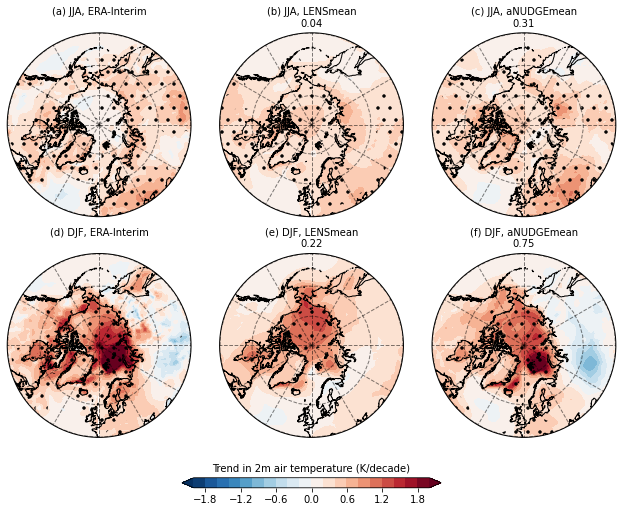

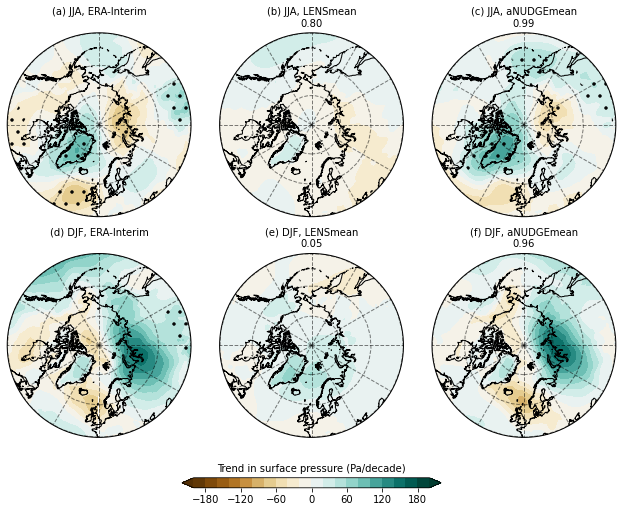

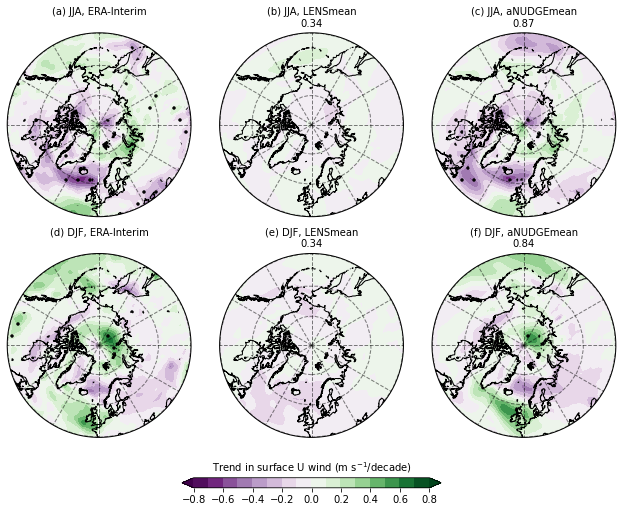

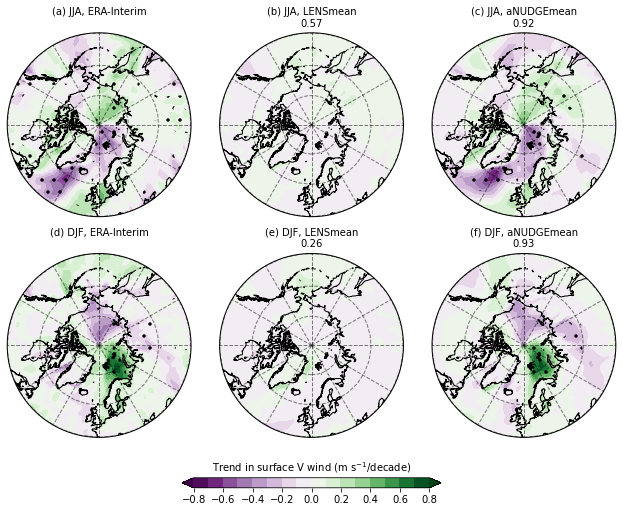

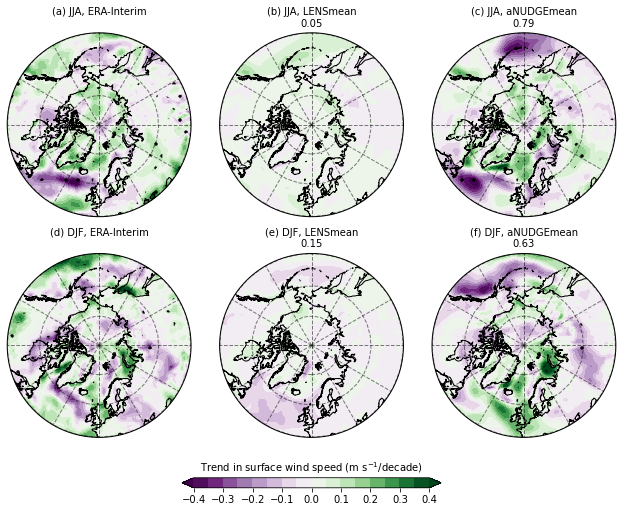

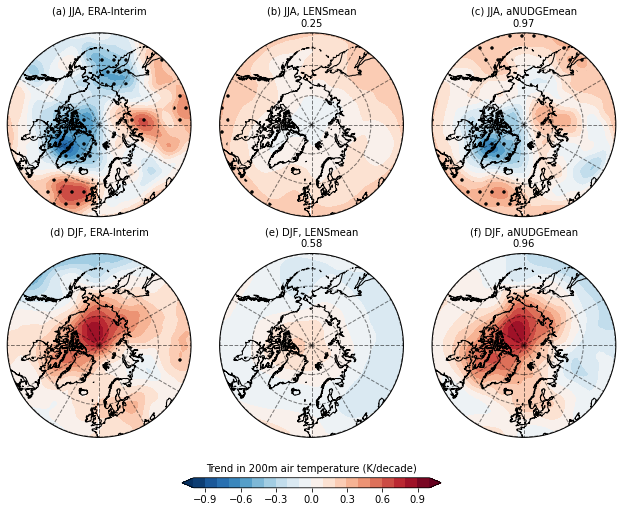

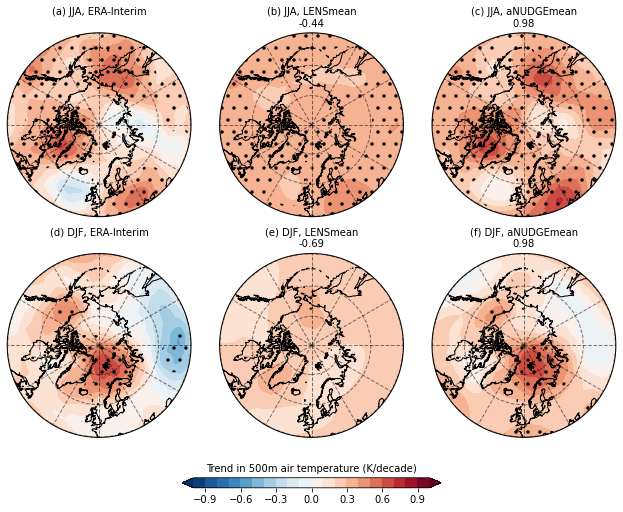

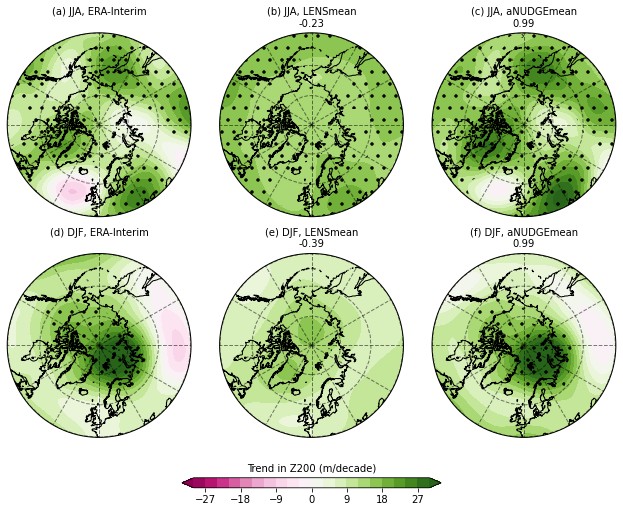

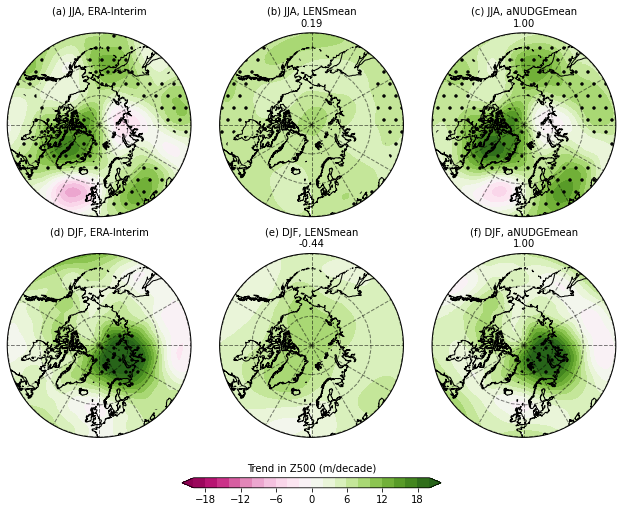

In [13]:
for v, var in enumerate(myvars):
    fig = plt.figure(figsize=(3*len(mynames),7))
    for ct, seas in enumerate(['JJA','DJF']):
        for n, name in enumerate(mynames):
            ax = plt.subplot(2,len(mynames),ct*len(mynames)+n+1, projection = ccrs.NorthPolarStereo())
            ax.set_extent([0.005, 360, 45, 90], crs=ccrs.PlateCarree())
            label = myf.alphabet[ct*len(mynames)+n]
            dmeridian = 30  # spacing for lines of meridian
            dparallel = 15  # spacing for lines of parallel 
            num_merid = int(360/dmeridian + 1)
            num_parra = int(90/dparallel + 1)
            gl = ax.gridlines(crs=ccrs.PlateCarree(), \
                              xlocs=np.linspace(0, 360, num_merid), \
                              ylocs=np.linspace(0, 90, num_parra), \
                              linestyle="--", linewidth=1, color='k', alpha=0.5)

            theta = np.linspace(0, 2*np.pi, 120)
            verts = np.vstack([np.sin(theta), np.cos(theta)]).T
            center, radius = [0.5, 0.5], 0.5
            circle = mpath.Path(verts * radius + center)
            ax.set_boundary(circle, transform=ax.transAxes)  #without this; get rect bound
            
            if np.nanmax(abs(10.*ds[var].sel(season=seas).sel(names=name).values ))>0:
                CS1 = ax.contourf(ds.lon,ds.lat, 10.*ds[var].sel(season=seas).sel(names=name).values , **myf.geoplotprop[var], transform=ccrs.PlateCarree(), extend='both')
       
            if (ds[var.split('_')[0]+'_p_value'].sel(season=seas).sel(names=name).min().values)<5:
                stip = plt.contourf(ds.lon,ds.lat, ds[var.split('_')[0]+'_p_value'].sel(season=seas).sel(names=name), levels = [0,5], 
                    transform=ccrs.PlateCarree(), colors=['none'], hatches=['.'])

            ax.coastlines("50m")
        
            pcorr = ''
            if n>0:
                corr, pval = myf.pearson(northds[var].sel(season=seas).sel(names='ERAI'), northds[var].sel(season=seas).sel(names=name), 'z')
                pcorr = '{:.2f}'.format(corr.values)
            ax.set_title(str(label)+' '+seas+', '+['ERA-Interim','LENSmean','aNUDGEmean'][n]+'\n'+pcorr,fontsize=10,loc='center')
                           
    plt.tight_layout()
    plt.subplots_adjust(hspace=.2, bottom = .15)
    cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02]) #[left, bottom, width, height]
    cbar = fig.colorbar(CS1, cax=cbar_ax,  orientation='horizontal')
    cbar.ax.set_title(myf.geoplotprop[var]['label'],fontsize=10)
    fig.savefig('figs/'+var+'.pdf', dpi=500, bbox_inches='tight')
    plt.show()
    plt.close()

## Now plot sea ice concentration

In [15]:
mydir = './data/aice_spatial_clim_trend/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'aice_climtrend' in f]

obds = xr.open_dataset('./data/sst_spatial_mean_trend/HADISST.ocn_sst-trend-annmean.1979-2018.nc')
obds = obds.rename({'latitude':'lat','longitude':'lon'})

In [16]:
listds = []
for file in myfiles: 
    name = file.split('/')[-1].split('.')[0]
    if '_nh' in name:
        name = name[:-3]
    
    sicds = xr.open_dataset(file)
    if 'nlat' in sicds.dims:
        sicds = sicds.rename({'nlat':'nj','nlon':'ni','TLONG':'TLON'})
    sicds = sicds.sel(nj=slice(-104,None))
    sicds = sicds[['aice_trend','aice_clim','aice_p_value']] 
    sicds['names'] = name
    sicds = sicds.set_coords('names')
    # having problems with matplotlib and the CESM ocean lat lon coords
    # so I will regrid to HADISST grid for plotting
    sicds = sicds.rename({'TLAT':'lat','TLON':'lon'})
    regridder = xe.Regridder(sicds, obds, 'bilinear')#, reuse_weights=True)
    sicds = regridder(sicds)

    listds.append(sicds)
sicds = xr.concat(listds,dim='names',coords='minimal',compat='override')

In [18]:
thelens = [f for f in sicds.names.values if 'LENS' in f]
lensmean = sicds.isel(names=0).copy()
for var in sicds:
    lensmean[var] = sicds[var].sel(names=thelens).mean(dim='names')
lensmean['names'] = 'LENSmean'
lensmean = lensmean.set_coords('names')

In [19]:
thenudge = ['anom_nudge_era_60','anom_nudge_era_60_archi','anom_nudge_era_60_arclo']
a60nudgemean = sicds.isel(names=0).copy()
for var in sicds:
    a60nudgemean[var] = sicds[var].sel(names=thenudge).mean(dim='names')
a60nudgemean['names'] = 'aNUDGEmean'
a60nudgemean = a60nudgemean.set_coords('names')

In [20]:
sicds = xr.concat([sicds,lensmean,a60nudgemean],dim='names')

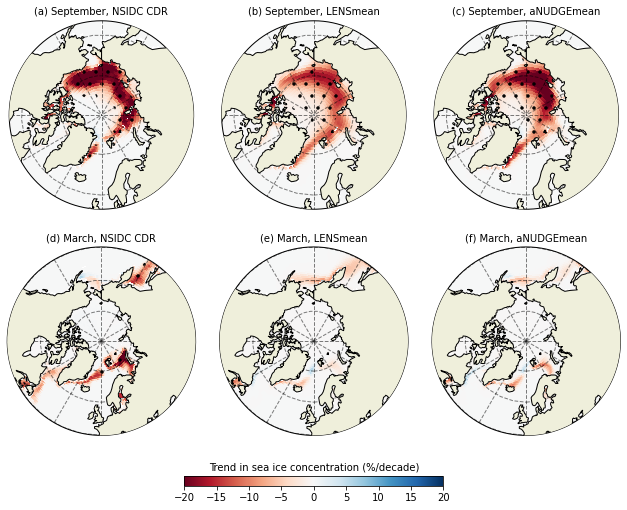

In [21]:
mynames = ['OBS-CDRv4-cdr', 'LENSmean','aNUDGEmean']

fig = plt.figure(figsize=(3*len(mynames),7))
for ct, month in enumerate([9,3]):
    for n, name in enumerate(mynames):

        ax = plt.subplot(2,len(mynames),ct*len(mynames)+n+1,projection =ccrs.NorthPolarStereo())
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
        ax.set_extent([0.005, 360, [55,45][ct], 90], crs=ccrs.PlateCarree())
        label = ['a','b','c','d','e','f'][ct*len(mynames)+n]
        
        dmeridian = 30  # spacing for lines of meridian
        dparallel = 15  # spacing for lines of parallel 
        num_merid = int(360/dmeridian + 1)
        num_parra = int(90/dparallel + 1)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), \
                          xlocs=np.linspace(0, 360, num_merid), \
                          ylocs=np.linspace(0, 90, num_parra), \
                          linestyle="--", linewidth=1, color='k', alpha=0.5)

        theta = np.linspace(0, 2*np.pi, 120)
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        center, radius = [0.5, 0.5], 0.5
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)  #without this; get rect bound

        mydata = 10.*sicds.aice_trend.sel(names=name).sel(month=month)
        mypval = sicds['aice_p_value'].sel(month=month).sel(names=name)
        mypval = mypval.where(abs(mydata)>1)
        mypval = mypval.where(mypval<5)
        
        CS1 = ax.pcolormesh(sicds.lon, sicds.lat, mydata,
                            cmap = plt.cm.RdBu, transform=ccrs.PlateCarree(),vmin=-20,vmax=20) 

  
        stip = plt.contourf(sicds.lon, sicds.lat, mypval, levels = [0.,5.], extend='neither',
                            transform=ccrs.PlateCarree(), colors=['none'], hatches=['.'])
        
        ax.set_title('('+str(label)+') '+['September','March'][ct]+', '+['NSIDC CDR','LENSmean','aNUDGEmean'][n],fontsize=10,loc='center')

plt.tight_layout()
plt.subplots_adjust(hspace=.2, bottom = .15)
cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02]) #[left, bottom, width, height]
cbar = fig.colorbar(CS1, cax=cbar_ax,  orientation='horizontal')
cbar.ax.set_title(r'Trend in sea ice concentration (%/decade)',fontsize=10)

fig.savefig('figs/sic_trend.pdf', dpi=500, bbox_inches='tight')
plt.show()
plt.close()

In [23]:
sictrend_iv = sicds.sel(names=[f for f in sicds.names.values if ('LENS' in f and f!='LENSmean')]).aice_trend.std(dim='names')

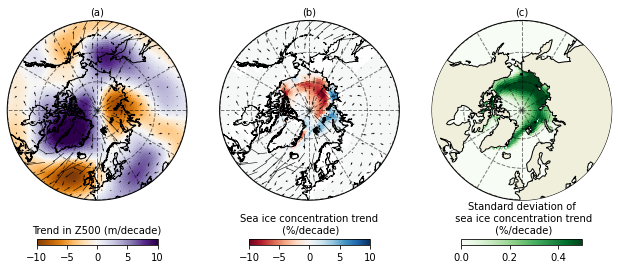

In [25]:
ds = ds.where(ds.lat>0.,drop=True)
 # have to do this for North Polar Stereo vector plots

diff = 10.*(ds.sel(names='aNUDGEmean') - ds.sel(names='LENSmean'))
sicdiff = 10.*(sicds.sel(names='aNUDGEmean') - sicds.sel(names='LENSmean'))

seas = 'JJA'
myvars = ['Z500_trend','aice_trend','aice_var']#,'hi_trend']

fig = plt.figure(figsize=(9,4))
for v, var in enumerate(myvars):  
   
    ax = plt.subplot(1,3, v+1, projection = ccrs.NorthPolarStereo())
    ax.set_extent([0.005, 360, 45, 90], crs=ccrs.PlateCarree())
    ax.set_title(myf.alphabet[v],fontsize=10,loc='center')

    dmeridian = 30  # spacing for lines of meridian
    dparallel = 15  # spacing for lines of parallel 
    num_merid = int(360/dmeridian + 1)
    num_parra = int(90/dparallel + 1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), \
                      xlocs=np.linspace(0, 360, num_merid), \
                      ylocs=np.linspace(0, 90, num_parra), \
                      linestyle="--", linewidth=1, color='k', alpha=0.5)

    theta = np.linspace(0, 2*np.pi, 120)
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    center, radius = [0.5, 0.5], 0.5
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)  #without this; get rect bound

    if var=='aice_trend': 
        CS1 = ax.pcolormesh(sicds.lon, sicds.lat, sicdiff.aice_trend.sel(month=9),
                            cmap = plt.cm.RdBu, transform=ccrs.PlateCarree(),vmin=-10, vmax=10)
        ax.coastlines("50m")
        cb = plt.colorbar(CS1,shrink=.6,orientation='horizontal')
        cb.ax.set_title('Sea ice concentration trend\n (%/decade)',fontsize=10)
        
    elif var=='aice_var':
        CS1 = ax.pcolormesh(sicds.lon, sicds.lat, sictrend_iv.sel(month=9),
                            cmap = plt.cm.Greens, transform=ccrs.PlateCarree(),vmin=0, vmax=.5)
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
        cb = plt.colorbar(CS1,shrink=.6,orientation='horizontal')
        cb.ax.set_title('Standard deviation of\n sea ice concentration trend\n (%/decade)',fontsize=10)
       
    else:
        val = 0.5*myf.geoplotprop[var]['levels'].max()
        CS1 = ax.pcolormesh(ds.lon,ds.lat, diff[var].sel(season=seas) , cmap = plt.cm.PuOr, 
                              transform=ccrs.PlateCarree(), vmin=-val, vmax=val )
        
        ax.coastlines("50m") 
        cb = plt.colorbar(CS1,shrink=.6,orientation='horizontal')
        cb.ax.set_title(myf.geoplotprop[var]['label'],fontsize=10)

    if v!=2:
        Q = ax.quiver(ds.lon.values, ds.lat.values, diff.U_trend.sel(season=seas).values, diff.V_trend.sel(season=seas).values, 
                      transform=ccrs.PlateCarree(), regrid_shape=20 )
             
plt.tight_layout()
plt.subplots_adjust(hspace=.2)
fig.savefig('figs/aNUDGEminusLENSmean.pdf', dpi=500, bbox_inches='tight')
plt.show()
plt.close()

## Read in SIE and GMST timeseries

In [26]:
mydir = './data/sia_sie_siv_timeseries/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'nh' in f]
listds = []
for f in myfiles:
    if 'OB' not in f:
        sids = xr.open_dataset(f)[['sie_nh']]
        sids = sids.set_coords('names')
        myname = str(sids.names.values)
        if 'LENS' in myname:
                sids['names'] = 'LENS'+myname[-2:]
        listds.append(sids)
sids = xr.concat(listds,dim='names')

In [27]:
sie_nh = myf.xr_reshape(sids.sie_nh,'time',['year','month'],[np.arange(1979,2018+1),np.arange(1,13,1)])
slope, intercept, r_value, p_value, std_err = myf.linregress(sie_nh.year, sie_nh.load(), dim='year')

In [28]:
mydir = './data/trefht_timeseries/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'trefht_timeseries' in f and ('LENS' in f or '60' in f or 'GIS' in f or 'ERAI' in f or 'Had' in f)]
mynames = sorted(list(set([f.split('.')[0].split('/')[-1] for f in myfiles])))
listds = []
for f in myfiles: 
        gmstds = xr.open_dataset(f).sel(region='Global')
        listds.append(gmstds)
gmstds = xr.concat(listds,dim='names').groupby('time.year').mean(dim='time')

In [29]:
gmst_slope, gmst_intercept, gmst_r_value, gmst_p_value, gmst_std_err = myf.linregress(gmstds.year, gmstds.load(), dim='year')

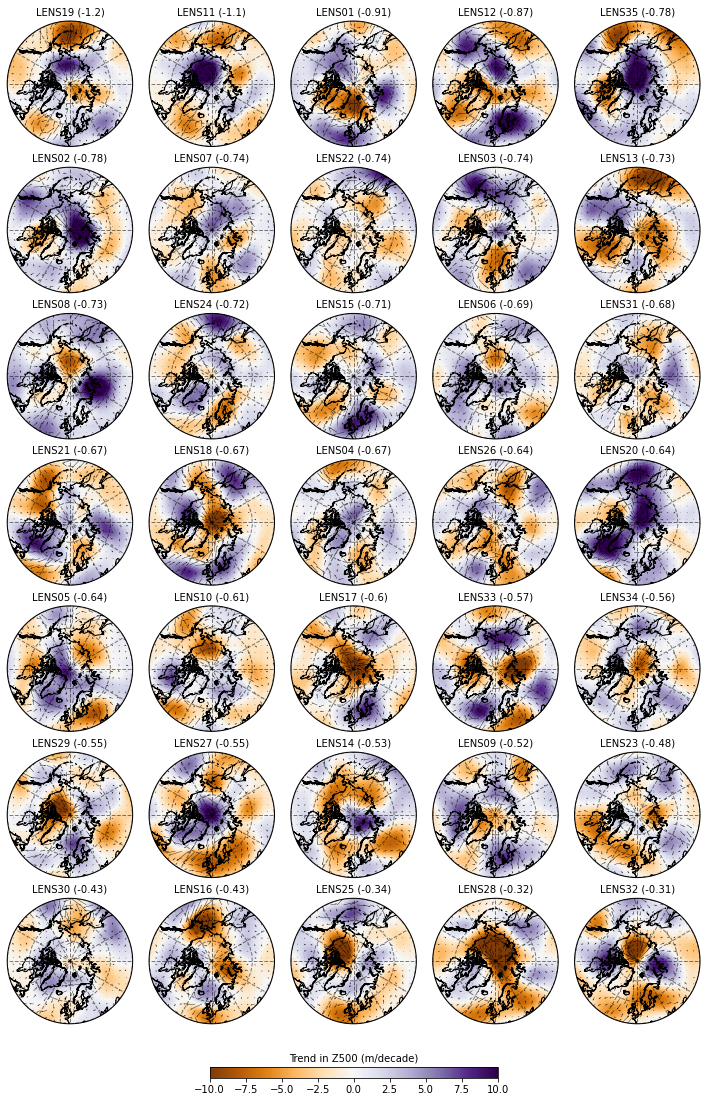

In [30]:
lens_sort = [f for f in slope.sel(month=9).sortby(slope.sel(month=9)).names.values if 'LENS' in f]
fig = plt.figure(figsize=(10,15))
for v, myname in enumerate(lens_sort):  
   
    ax = plt.subplot(7,5, v+1, projection = ccrs.NorthPolarStereo())
    ax.set_extent([0.005, 360, 45, 90], crs=ccrs.PlateCarree())
    ax.set_title(myname+' ({:.2})'.format(10.*slope.sel(month=9).sel(names=myname).values),fontsize=10,loc='center')

    dmeridian = 30  # spacing for lines of meridian
    dparallel = 15  # spacing for lines of parallel 
    num_merid = int(360/dmeridian + 1)
    num_parra = int(90/dparallel + 1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), \
                      xlocs=np.linspace(0, 360, num_merid), \
                      ylocs=np.linspace(0, 90, num_parra), \
                      linestyle="--", linewidth=1, color='k', alpha=0.5)

    theta = np.linspace(0, 2*np.pi, 120)
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    center, radius = [0.5, 0.5], 0.5
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)  #without this; get rect bound
    
    diff = 10.*(ds.sel(names=myname) - ds.sel(names='LENSmean'))
    
    val = 0.5*myf.geoplotprop['Z500_trend']['levels'].max()
    CS1 = ax.pcolormesh(ds.lon,ds.lat, diff.Z500_trend.sel(season=seas) , cmap = plt.cm.PuOr, 
                          transform=ccrs.PlateCarree(), vmin=-val, vmax=val )
    
    Q = ax.quiver(ds.lon.values, ds.lat.values, diff.U_trend.sel(season=seas).values, diff.V_trend.sel(season=seas).values, 
                      transform=ccrs.PlateCarree(), regrid_shape=20 )
   

    ax.coastlines("50m") 
plt.tight_layout()
plt.subplots_adjust(bottom=.05)
cbar_ax = fig.add_axes([0.3, 0.0, 0.4, 0.01]) #[left, bottom, width, height]
cb = fig.colorbar(CS1, cax=cbar_ax,  orientation='horizontal')

cb.ax.set_title(myf.geoplotprop['Z500_trend']['label'],fontsize=10)


plt.show()
fig.savefig('figs/LENS_Z500_trend.pdf', dpi=800, bbox_inches='tight')
plt.close()

# Regressions with September sea ice extent trend

In [31]:
lens_sie_trend_sep = slope.sel(names=[f for f in slope.names.values if 'LENS' in f]).sel(month=9)
lens_sie_trend_sep['names'] = [f for f in ds.names.values if 'LENS' in f and 'mean' not in f]

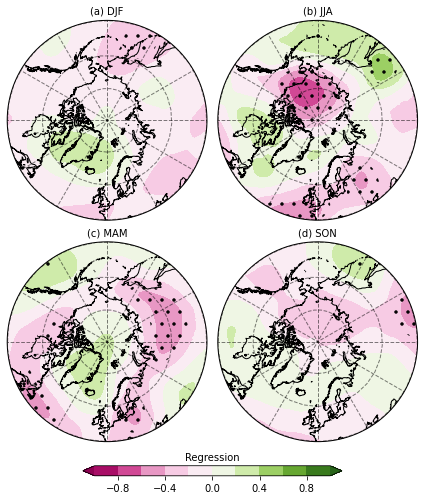

In [32]:
var = 'Z500_trend'
xdata = ds[var].squeeze().sel(names = [f for f in ds.names.values if 'LEN' in f and 'mean' not in f])
xdata = xdata.where(xdata==xdata,0.)
corr, pval = myf.pearson(xdata, lens_sie_trend_sep, 'names')

fig = plt.figure(figsize=(6,7))

for s, seas in enumerate(ds.season.values):
    ax = plt.subplot(2,2,1+s, projection = ccrs.NorthPolarStereo())
    ax.set_extent([0.005, 360, 45, 90], crs=ccrs.PlateCarree())
    dmeridian = 30  # spacing for lines of meridian
    dparallel = 15  # spacing for lines of parallel 
    num_merid = int(360/dmeridian + 1)
    num_parra = int(90/dparallel + 1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), \
                      xlocs=np.linspace(0, 360, num_merid), \
                      ylocs=np.linspace(0, 90, num_parra), \
                      linestyle="--", linewidth=1, color='k', alpha=0.5)

    theta = np.linspace(0, 2*np.pi, 120)
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    center, radius = [0.5, 0.5], 0.5
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)  #without this; get rect bound
 
    ax.coastlines("50m")  
    CS1 = ax.contourf(ds.lon,ds.lat, corr.sel(season=seas) ,
                  transform=ccrs.PlateCarree(), cmap = plt.cm.PiYG, extend='both',
                 levels = np.arange(-1,1.2,.2))

    stip = ax.contourf(ds.lon,ds.lat, pval.sel(season=seas), levels = [0,.05], 
        transform=ccrs.PlateCarree(), colors=['none'], hatches=['.'])

    ax.set_title(myf.alphabet[s]+' '+seas,loc='center',fontsize=10)

plt.tight_layout()
plt.subplots_adjust(bottom=.1)

cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02]) #[left, bottom, width, height]
cbar = fig.colorbar(CS1, cax=cbar_ax,  orientation='horizontal')
cbar.ax.set_title('Regression',fontsize=10)
#plt.suptitle(var+' with September SIE trend')

fig.savefig('figs/regression_'+var+'.pdf', dpi=500, bbox_inches='tight')
plt.show()
plt.close()